In [51]:
import numpy as np
import pandas as pd
import pickle
#import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
#Retrieve pickle object
fileObj = open('data_algos.pkl', 'rb')
all_generations = pickle.load(fileObj)
fileObj.close()

In [53]:
#creating one DataFrame for each selection method
generations_df = pd.DataFrame(all_generations)
new_generations_df=generations_df[generations_df['mutation']==0]
#checking the results
new_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
49039,1.764706,280,0.018668,Random Selection,50,0.0
307001,1.647059,206,0.018701,Ranked Selection,80,0.0
284672,1.647059,266,0.018701,Ranked Selection,70,0.0
192935,11.882353,43,0.001121,Ranked Selection,10,0.0
308982,1.647059,231,0.018701,Ranked Selection,80,0.0


In [54]:
#Sample Statistics
new_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])


radius                                            \
                             count       mean       std       min        50%   
selection_type   generation                                                    
Random Selection 0           550.0  15.290267  8.544880  0.117647  15.823529   
                 1           550.0  12.738182  7.534144  0.117647  12.117647   
                 2           550.0  10.460535  6.754695  0.117647   9.647059   
                 3           550.0   8.453476  5.961741  0.117647   7.764706   
                 4           550.0   6.527059  4.920252  0.117647   5.294118   
...                            ...        ...       ...       ...        ...   
Wheel Selection  345         550.0   1.899465  0.494220  1.529412   1.764706   
                 346         550.0   1.899465  0.494220  1.529412   1.764706   
                 347         550.0   1.899465  0.494220  1.529412   1.764706   
                 348         550.0   1.899465  0.494220  1.529412   1.764706   
                 349         550.0   1.899465  0.494220  1.529412   1.764706   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000   550.0  0.002665  0.004454  0.000177   
                 1           30.000000   550.0  0.003456  0.005083  0.000177   
                 2           26.823529   550.0  0.004450  0.005688  0.000221   
                 3           28.352941   550.0  0.005865  0.006261  0.000198   
                 4           23.529412   550.0  0.007401  0.006468  0.000287   
...                                ...     ...       ...       ...       ...   
Wheel Selection  345          4.117647   550.0  0.017940  0.001983  0.008257   
                 346          4.117647   550.0  0.017940  0.001983  0.008257   
                 347          4.117647   550.0  0.017940  0.001983  0.008257   
                 348          4.117647   550.0  0.017940  0.001983  0.008257   
                 349          4.117647   550.0  0.017940  0.001983  0.008257   

                             ...   pop_size                    mutation       \
                             ...        std   min   50%    max    count mean   
selection_type   generation  ...                                               
Random Selection 0           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 1           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 2           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 3           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 4           ...  24.517196  10.0  70.0  100.0    550.0  0.0   
...                          ...        ...   ...   ...    ...      ...  ...   
Wheel Selection  345         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 346         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 347         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 348         ...  24.517196  10.0  70.0  100.0    550.0  0.0   
                 349         ...  24.517196  10.0  70.0  100.0    550.0  0.0   

                                                 
                             std  min  50%  max  
selection_type   generation                      
Random Selection 0           0.0  0.0  0.0  0.0  
                 1           0.0  0.0  0.0  0.0  
                 2           0.0  0.0  0.0  0.0  
                 3           0.0  0.0  0.0  0.0  
                 4           0.0  0.0  0.0  0.0  
...                          ...  ...  ...  ...  
Wheel Selection  345         0.0  0.0  0.0  0.0  
                 346         0.0  0.0  0.0  0.0  
                 347         0.0  0.0  0.0  0.0  
                 348         0.0  0.0  0.0  0.0  
               

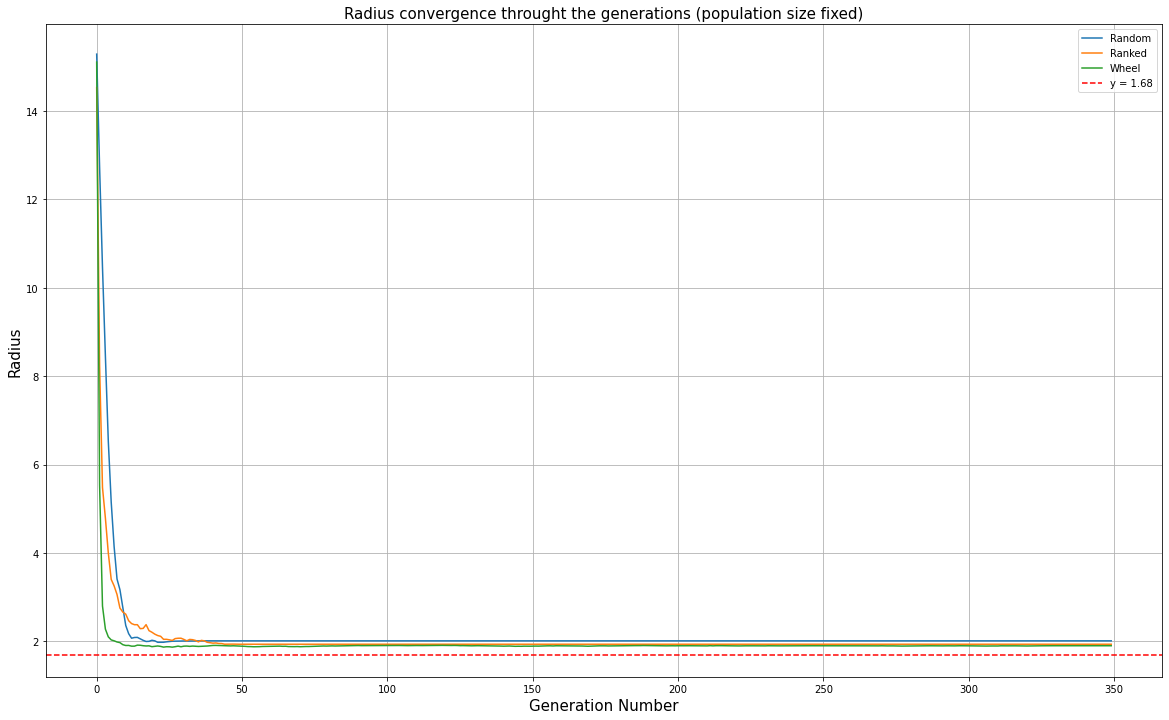

In [55]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

In [56]:
grouped.loc['Random Selection', 'radius']

generation
0      15.290267
1      12.738182
2      10.460535
3       8.453476
4       6.527059
         ...    
345     2.010695
346     2.010695
347     2.010695
348     2.010695
349     2.010695
Name: radius, Length: 350, dtype: float64

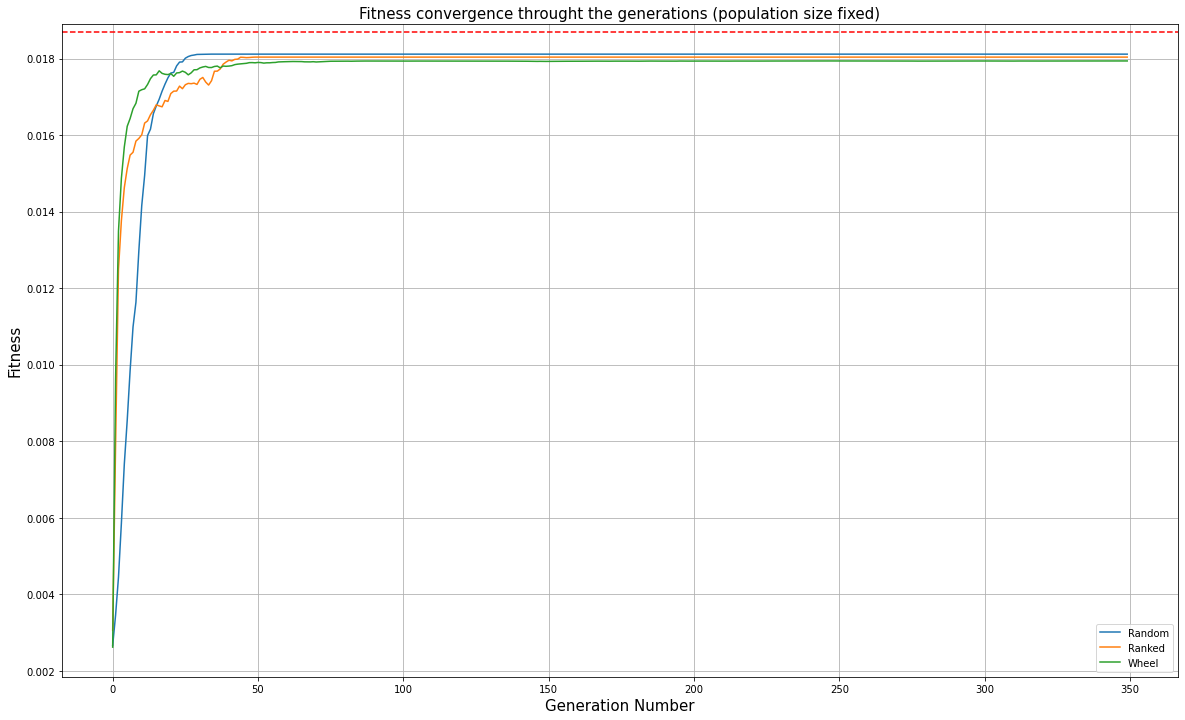

In [57]:
grouped = new_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

In [58]:
new_generations_df.groupby(by=['selection_type', 'pop_size']).describe(percentiles = [0.5])

radius                                            \
                             count       mean       std       min        50%   
selection_type   pop_size                                                      
Random Selection 10         3500.0   9.778487  0.511154  0.352941   9.764706   
                 20         7000.0   1.993378  1.250193  0.117647   1.882353   
                 30        10500.0   2.184941  1.152123  0.117647   2.117647   
                 40        14000.0   2.231126  1.198421  0.235294   2.117647   
                 50        17500.0   2.010030  1.975409  0.117647   1.764706   
                 60        21000.0   2.059754  1.571199  0.235294   1.882353   
                 70        24500.0   2.034391  1.361221  0.117647   1.882353   
                 80        28000.0   1.807618  1.489632  0.117647   1.647059   
                 90        31500.0   2.032657  1.414674  0.117647   1.882353   
                 100       35000.0   2.020165  1.307343  0.235294   1.882353   
Ranked Selection 10         3500.0  11.953412  0.944380  1.882353  11.882353   
                 20         7000.0   2.128387  1.146354  0.588235   2.000000   
                 30        10500.0   3.095059  1.988965  0.941176   2.823529   
                 40        14000.0   1.768454  2.021132  0.235294   1.411765   
                 50        17500.0   2.163576  1.925200  0.117647   1.882353   
                 60        21000.0   1.743653  1.304413  0.117647   1.647059   
                 70        24500.0   1.691755  0.818426  0.352941   1.647059   
                 80        28000.0   1.702697  0.970999  0.117647   1.647059   
                 90        31500.0   1.807955  0.844749  0.470588   1.764706   
                 100       35000.0   1.696397  0.932602  0.117647   1.647059   
Wheel Selection  10         3500.0   2.414084  0.757212  2.352941   2.352941   
                 20         7000.0   4.198958  0.897550  3.882353   4.117647   
                 30        10500.0   2.377434  0.910247  0.117647   2.352941   
                 40        14000.0   2.273479  0.805814  0.117647   2.235294   
                 50        17500.0   2.064457  0.960148  0.117647   2.000000   
                 60        21000.0   1.700045  0.906920  0.117647   1.647059   
                 70        24500.0   1.752341  0.881561  0.117647   1.764706   
                 80        28000.0   1.581429  0.876888  0.117647   1.529412   
                 90        31500.0   1.962174  1.014774  0.117647   1.882353   
                 100       35000.0   1.710528  0.961485  0.117647   1.647059   

                                     generation                          ...  \
                                 max      count   mean         std  min  ...   
selection_type   pop_size                                                ...   
Random Selection 10        26.823529     3500.0  174.5  101.050322  0.0  ...   
                 20        29.882353     7000.0  174.5  101.043102  0.0  ...   
                 30        29.058824    10500.0  174.5  101.040696  0.0  ...   
                 40        30.000000    14000.0  174.5  101.039493  0.0  ...   
                 50        29.529412    17500.0  174.5  101.038772  0.0  ...   
                 60        29.882353    21000.0  174.5  101.038290  0.0  ...   
                 70        29.529412    24500.0  174.5  101.037947  0.0  ...   
                 80        28.823529    28000.0  174.5  101.037689  0.0  ...   
                 90        29.058824    31500.0  174.5  101.037488  0.0  ...   
                 100       30.000000    35000.0  174.5  101.037328  0.0  ...   
Ranked Selection 10        27.882353     3500.0  174.5  101.050322  0.0  ...   
                 20        28.705882     7000.0  174.5  101.043102  0.0  ...   
                 30        29.882353    10500.0  174.5  101.040696  0.0  ...   
                 40        29.764706    14000.0  174.5  101.039493  0.0  ...   
                 50        

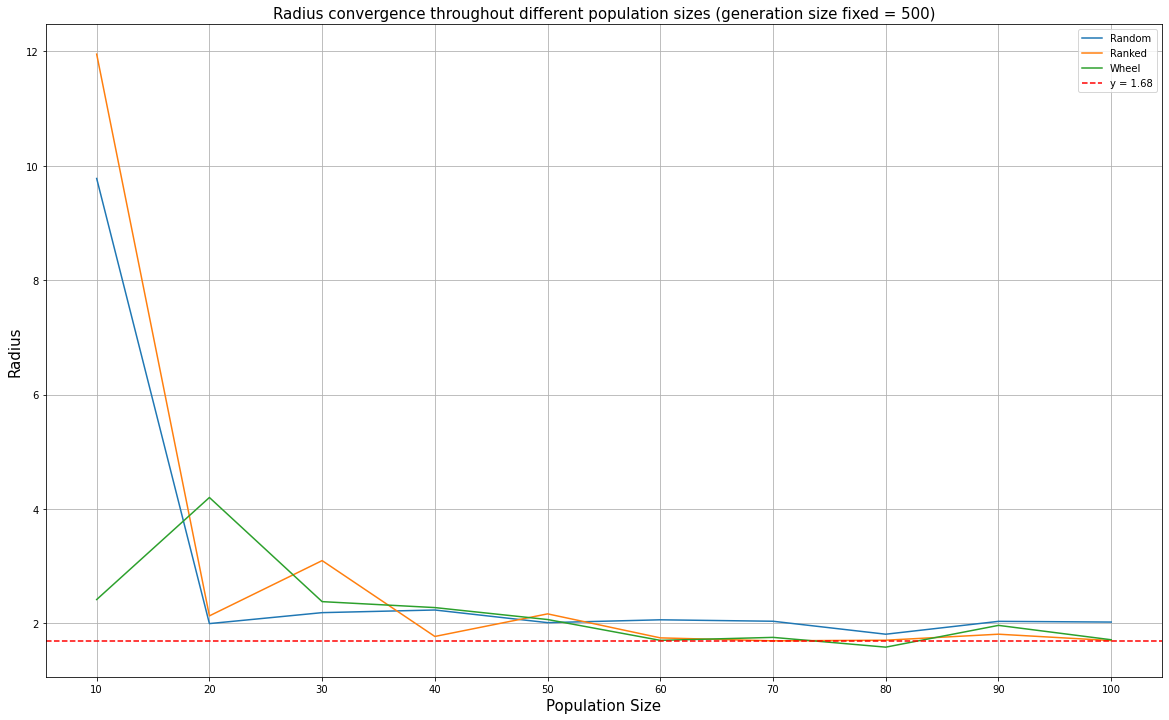

In [59]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [60]:
grouped_pop.loc['Random Selection', 'radius'].values

array([9.77848739, 1.99337815, 2.18494118, 2.23112605, 2.01003025,
       2.0597535 , 2.03439136, 1.80761765, 2.03265733, 2.02016471])

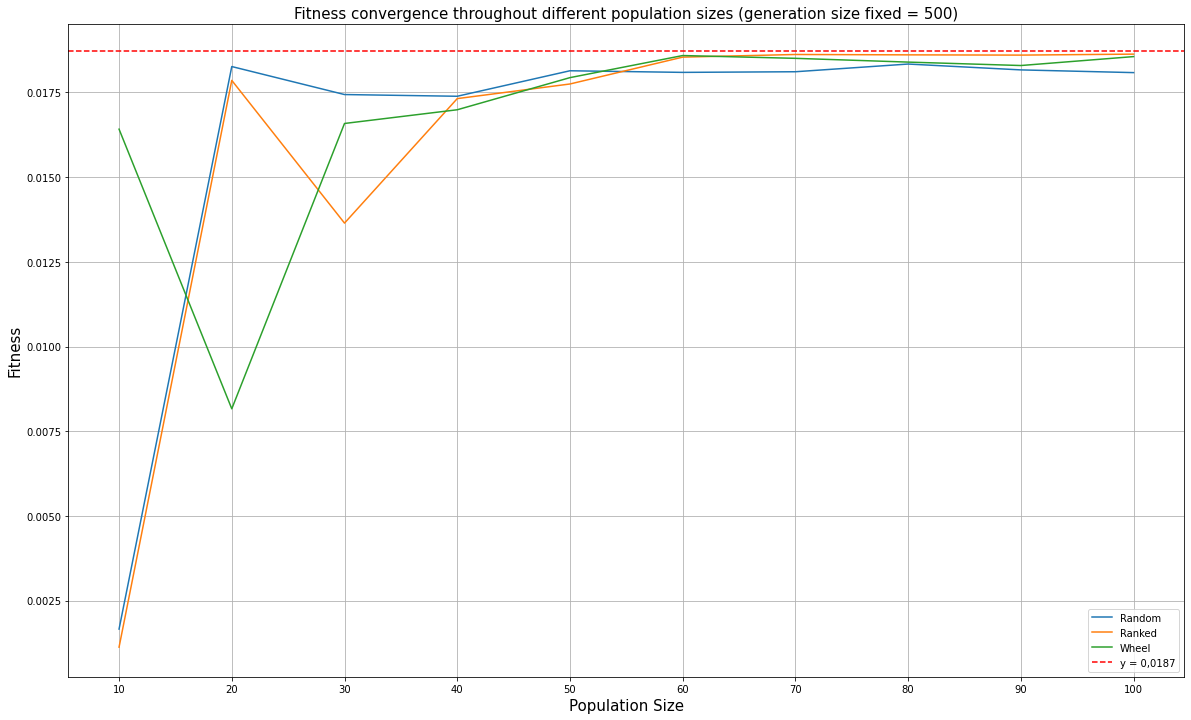

In [61]:
grouped_pop = new_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'fitness']))
y1 = grouped_pop.loc['Random Selection', 'fitness']
y2 = grouped_pop.loc['Ranked Selection', 'fitness']
y3 = grouped_pop.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()

WITH MUTATIONS

In [62]:
mutation_generations_df=generations_df[generations_df['mutation']!=0]
#checking the results
mutation_generations_df.sample(5)

,radius,generation,fitness,selection_type,pop_size,mutation
1090620,1.529412,23,0.018543,Wheel Selection,90,0.001
1057964,2.000000,313,0.018138,Wheel Selection,70,0.001
2584222,1.176471,117,0.016751,Ranked Selection,70,0.100
1524194,5.411765,191,0.005125,Ranked Selection,100,0.010
1163609,3.764706,255,0.009525,Random Selection,20,0.010


In [63]:
#Sample Statistics
mutation_generations_df.groupby(by=['selection_type', 'generation']).describe(percentiles = [0.5])

radius                                            \
                              count       mean       std       min        50%   
selection_type   generation                                                     
Random Selection 0           2200.0  14.927380  8.566053  0.117647  14.823529   
                 1           2200.0  12.706631  7.397494  0.117647  12.588235   
                 2           2200.0  10.875936  6.691119  0.117647  10.588235   
                 3           2200.0   9.506043  6.178691  0.117647   9.058824   
                 4           2200.0   8.349519  5.594953  0.117647   8.000000   
...                             ...        ...       ...       ...        ...   
Wheel Selection  345         2200.0   3.011176  3.691631  0.117647   1.882353   
                 346         2200.0   3.045882  3.752264  0.117647   1.882353   
                 347         2200.0   3.167807  3.980880  0.117647   1.882353   
                 348         2200.0   3.108503  3.844330  0.117647   1.882353   
                 349         2200.0   3.041123  3.683364  0.117647   1.882353   

                                       fitness                                \
                                   max   count      mean       std       min   
selection_type   generation                                                    
Random Selection 0           30.000000  2200.0  0.002889  0.004680  0.000177   
                 1           29.882353  2200.0  0.003361  0.004908  0.000178   
                 2           29.882353  2200.0  0.003972  0.005140  0.000178   
                 3           29.764706  2200.0  0.004714  0.005508  0.000180   
                 4           29.882353  2200.0  0.005266  0.005607  0.000178   
...                                ...     ...       ...       ...       ...   
Wheel Selection  345         28.235294  2200.0  0.015147  0.005579  0.000200   
                 346         29.294118  2200.0  0.015090  0.005637  0.000185   
                 347         25.529412  2200.0  0.015039  0.005786  0.000244   
                 348         30.000000  2200.0  0.015041  0.005771  0.000177   
                 349         27.176471  2200.0  0.014960  0.005809  0.000215   

                             ...   pop_size                    mutation  \
                             ...        std   min   50%    max    count   
selection_type   generation  ...                                          
Random Selection 0           ...  24.500466  10.0  70.0  100.0   2200.0   
                 1           ...  24.500466  10.0  70.0  100.0   2200.0   
                 2           ...  24.500466  10.0  70.0  100.0   2200.0   
                 3           ...  24.500466  10.0  70.0  100.0   2200.0   
                 4           ...  24.500466  10.0  70.0  100.0   2200.0   
...                          ...        ...   ...   ...    ...      ...   
Wheel Selection  345         ...  24.500466  10.0  70.0  100.0   2200.0   
                 346         ...  24.500466  10.0  70.0  100.0   2200.0   
                 347         ...  24.500466  10.0  70.0  100.0   2200.0   
                 348         ...  24.500466  10.0  70.0  100.0   2200.0   
                 349         ...  24.500466  10.0  70.0  100.0   2200.0   

                                                                  
                                mean       std    min   50%  max  
selection_type   generation                                       
Random Selection 0           0.04025  0.039127  0.001  0.03  0.1  
                 1           0.04025  0.039127  0.001  0.03  0.1  
                 2           0.04025  0.039127  0.001  0.03  0.1  
                 3           0.04025  0.039127  0.001  0.03  0.1  
                 4           0.04025  0.039127  0.001  0.03  0.1  
...                              ...       ...    ...   ...  ...  
Wheel Selection  345         0.04025  0.039127  0.001  0.03  0.1  
                 346         0.04025  0.039127  0.00

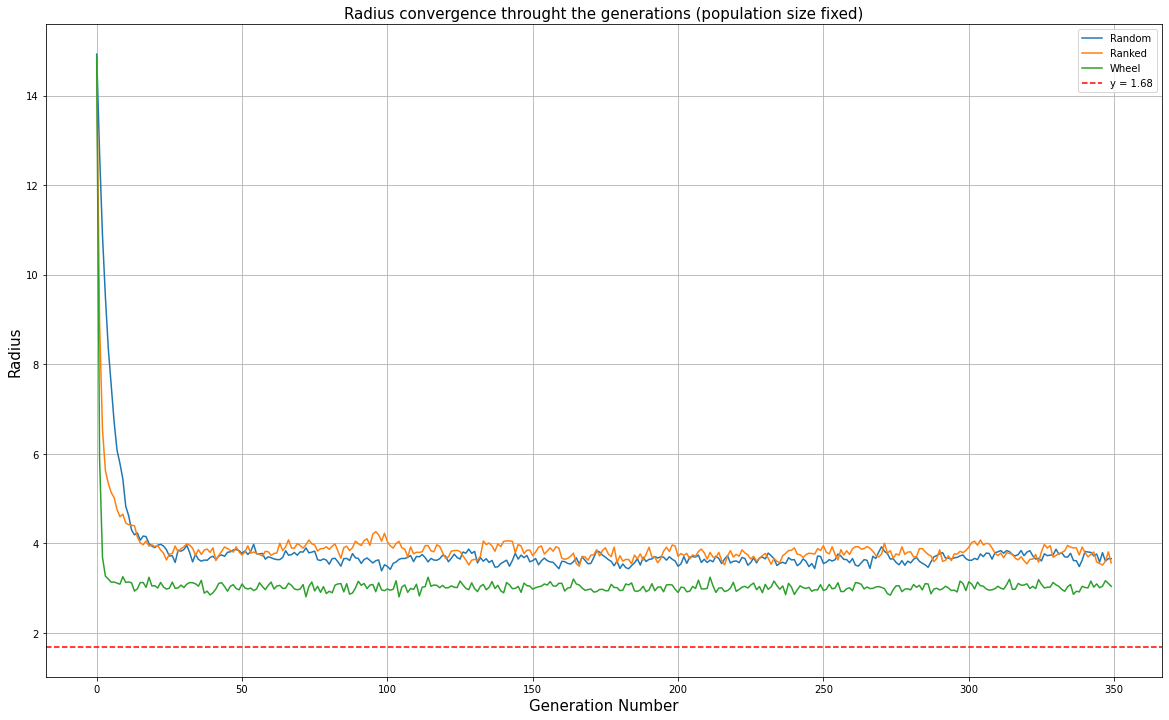

In [64]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'radius']
y2 = grouped.loc['Ranked Selection', 'radius']
y3 = grouped.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.show()

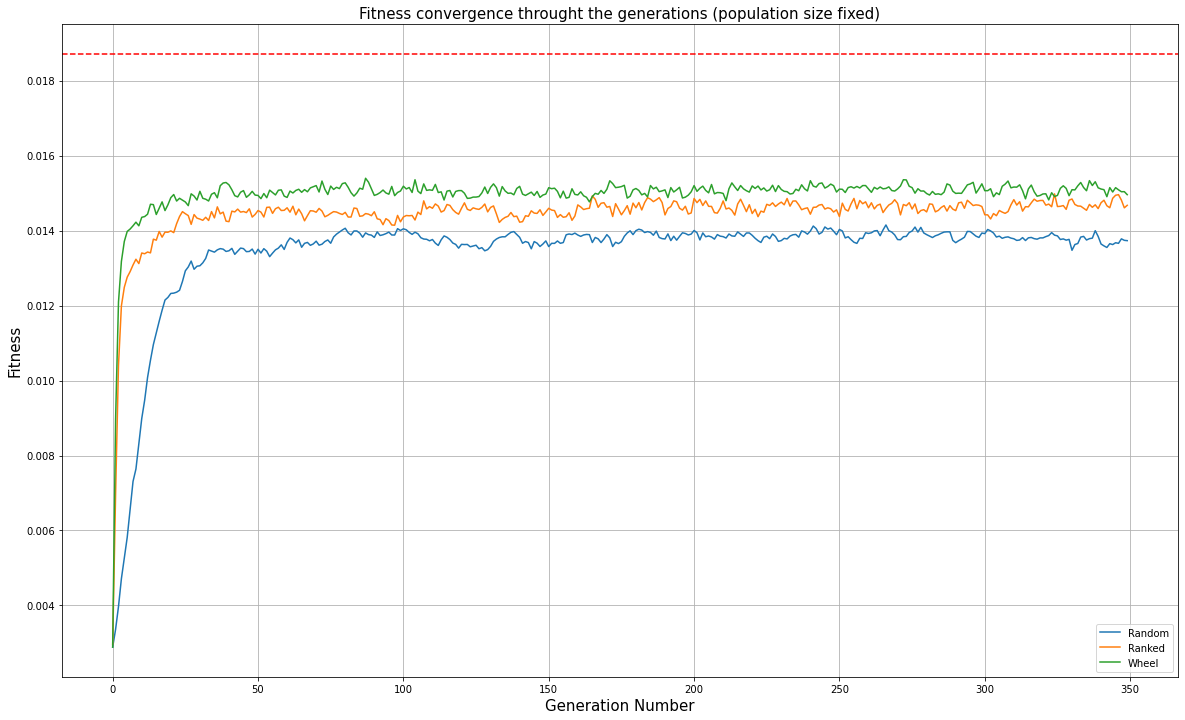

In [65]:
grouped = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped.loc['Random Selection', 'fitness']))
y1 = grouped.loc['Random Selection', 'fitness']
y2 = grouped.loc['Ranked Selection', 'fitness']
y3 = grouped.loc['Wheel Selection', 'fitness']

plt.title('Fitness convergence throught the generations (population size fixed)',fontsize=15)
plt.xlabel('Generation Number',fontsize=15)
plt.ylabel('Fitness',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  
plt.grid()
plt.legend()
plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')

plt.show()

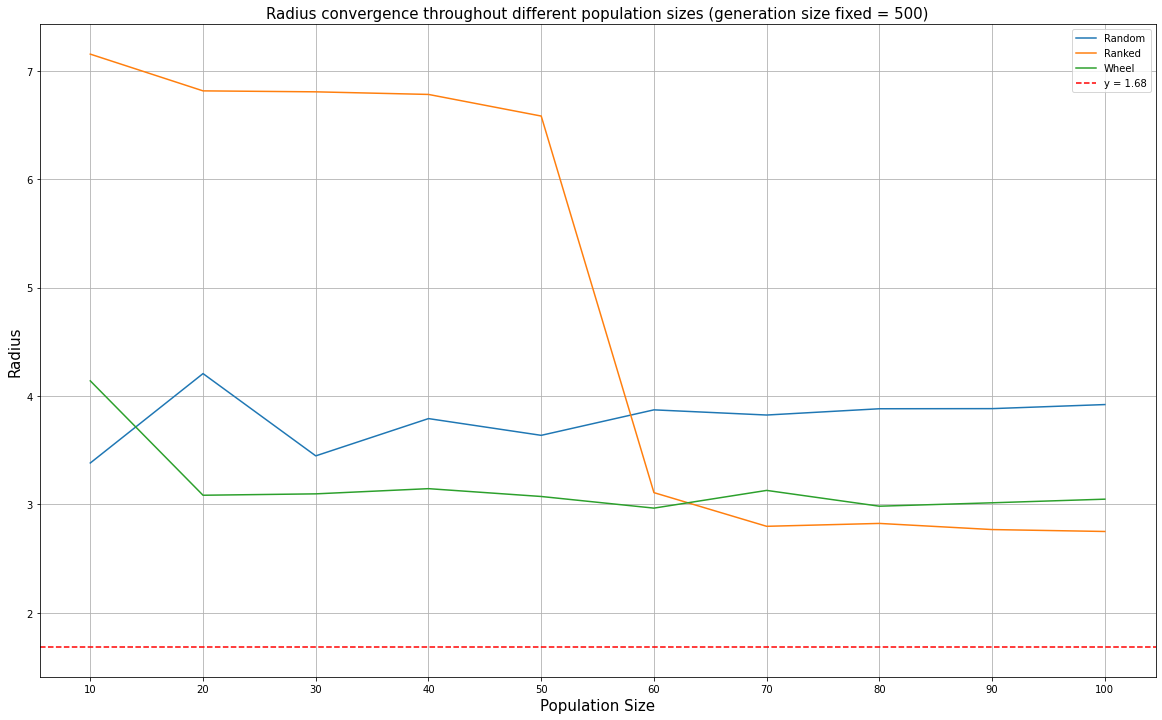

In [66]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'pop_size']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop.loc['Random Selection', 'radius']
y2 = grouped_pop.loc['Ranked Selection', 'radius']
y3 = grouped_pop.loc['Wheel Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = 'Random')
plt.plot(x1,y2,label = 'Ranked') 
plt.plot(x1,y3, label = 'Wheel')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

In [67]:
#mutation_generations_df=generations_df[generations_df['mutation']!=0]
mutation_generations_df=generations_df
mutation_generations_df= mutation_generations_df[mutation_generations_df['selection_type']=='Ranked Selection']
mutation_generations_df= mutation_generations_df[mutation_generations_df['pop_size']== 50]
mutation_generations_df.head()

,radius,generation,fitness,selection_type,pop_size,mutation
227500,1.882353,0,0.018471,Ranked Selection,50,0.0
227501,1.411765,0,0.018174,Ranked Selection,50,0.0
227502,2.117647,0,0.017696,Ranked Selection,50,0.0
227503,2.705882,0,0.014667,Ranked Selection,50,0.0
227504,2.823529,0,0.014017,Ranked Selection,50,0.0


In [68]:
grouped_pop = mutation_generations_df.groupby(by=['mutation','generation']).mean()
grouped_pop

radius   fitness  pop_size
mutation generation                               
0.0      0           13.400000  0.003754      50.0
         1           13.868235  0.003300      50.0
         2           13.044706  0.004455      50.0
         3           13.360000  0.004203      50.0
         4           11.348235  0.005048      50.0
...                        ...       ...       ...
0.1      345         11.840000  0.004063      50.0
         346         11.816471  0.003817      50.0
         347         11.868235  0.002712      50.0
         348         10.654118  0.003475      50.0
         349         10.621176  0.003302      50.0

[1750 rows x 3 columns]

In [69]:
fuck_you = np.array(list(grouped_pop['radius'].index)).transpose()
fuck_you[0]

array([0. , 0. , 0. , ..., 0.1, 0.1, 0.1])

In [70]:
list(fuck_you[0]).index(0.001)

350

ValueError: x and y must have same first dimension, but have shapes (500,) and (250,)

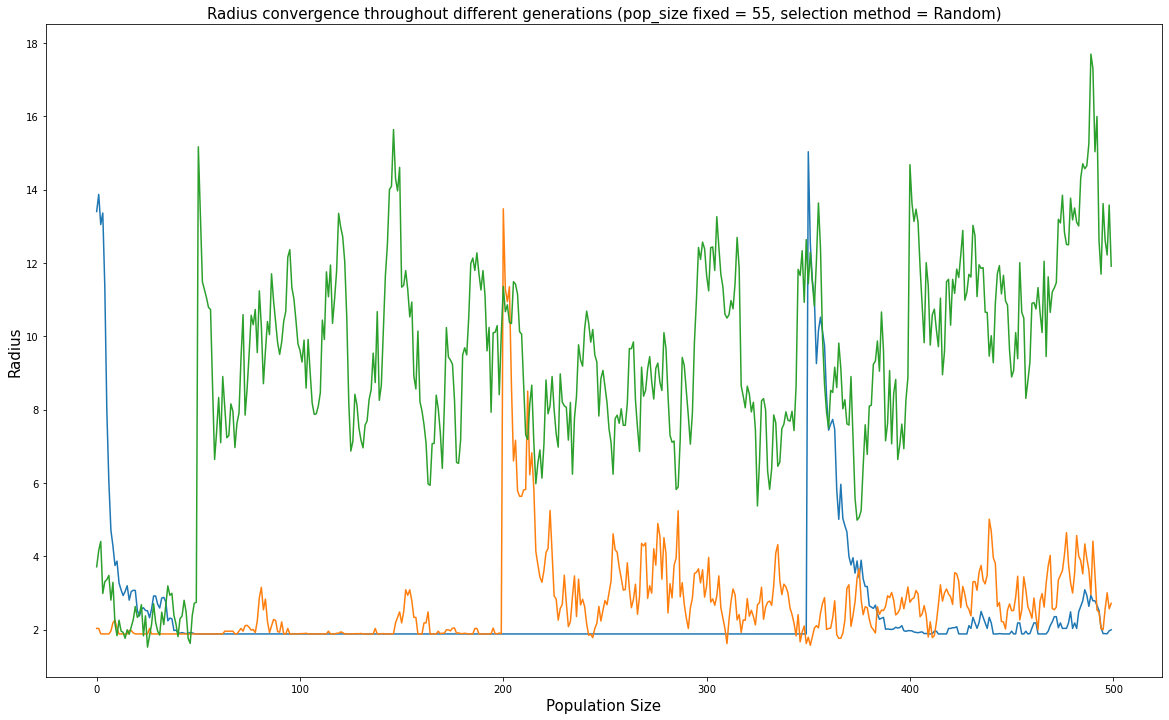

In [71]:
cutoff_point = list(fuck_you[0]).index(0.001)
grouped_pop = mutation_generations_df.groupby(by=['mutation', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(500)
y1 = (grouped_pop['radius'].values)[:cutoff_point]
y2 = (grouped_pop['radius'].values)[cutoff_point:2*cutoff_point]
y3 = (grouped_pop['radius'].values)[2*cutoff_point:3*cutoff_point]
y4 = (grouped_pop['radius'].values)[3*cutoff_point:4*cutoff_point]
y5 = (grouped_pop['radius'].values)[4*cutoff_point:]

plt.title('Radius convergence throughout different generations (pop_size fixed = 55, selection method = Random)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1, label = 'No Mutation') 
plt.plot(x1,y2,label = 'Mutation = 0.1%')
plt.plot(x1,y3,label = 'Mutation = 1%') 
plt.plot(x1,y4, label = 'Mutation = 5%')  
plt.plot(x1,y5, label = 'Mutation = 10%')


plt.grid()
#plt.axhline(y=0.018709891942760622, color='r', linestyle='--', label='y = 0,0187')
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
#plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.legend()

plt.show()

In [ ]:
grouped_pop = mutation_generations_df.groupby(by=['selection_type', 'generation']).mean()
#create plots

plt.rcParams["figure.figsize"]=(20,12)

x1 = range(len(grouped_pop.loc['Random Selection', 'radius']))
y1 = grouped_pop[grouped_pop['mutation'] == 0.001].loc['Random Selection', 'radius']
y2 = grouped_pop[grouped_pop['mutation'] == 0.01].loc['Random Selection', 'radius']
y3 = grouped_pop[grouped_pop['mutation'] == 0.1].loc['Random Selection', 'radius']
y4 = grouped_pop[grouped_pop['mutation'] == 0.05].loc['Random Selection', 'radius']

plt.title('Radius convergence throughout different population sizes (generation size fixed = 500)',fontsize=15)
plt.xlabel('Population Size',fontsize=15)
plt.ylabel('Radius',fontsize=15)

plt.plot(x1,y1,label = '0.1%')
plt.plot(x1,y2,label = '1%') 
plt.plot(x1,y3, label = '10%') 
plt.plot(x1,y4, label = '5%')  

plt.grid()
plt.axhline(y=1.6841, color='r', linestyle='--', label='y = 1.68')
plt.legend()

plt.xticks(range(len(grouped_pop.loc['Random Selection', 'radius'])), labels=grouped_pop.loc['Random Selection', 'radius'].index)
plt.show()

KeyError: 'Random Selection'